### Imports

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import umap
from sklearn.preprocessing import PowerTransformer
from tqdm.notebook import tqdm, trange
from sklearn.metrics import davies_bouldin_score
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from prince import FAMD, PCA
from sklearn.preprocessing import StandardScaler
from kmodes.kprototypes import KPrototypes
# import plotly.graph_objects as go
import warnings
warnings.filterwarnings("ignore")


#Our own librabries
import sys
sys.path.insert(1, '../../Environnement/')
from utils import clean_data, add_Loss, regroupe_crop
import clean
import merge

## Import and clean data 

In [2]:
#Select the dataset of one season of one year
YEAR = 2019
SEASON = "Rabi" # or "Kharif" 

#Path to the dataset
pathData_R = f"../../Data/RawDataUnified/RawData_{YEAR}_Rabi"
pathData_K= f"../../Data/RawDataUnified/RawData_{YEAR}_Kharif"


df_R = pd.read_csv(pathData_R)
df_K = pd.read_csv(pathData_K)

In [3]:
#Clean an add loss to data
df_R=add_Loss(clean_data(df_R))
df_K=add_Loss(clean_data(df_K))

df_R.head()

,Crop,Area Sown (Ha),Area Insured (Ha),SI Per Ha (Inr/Ha),Lp_2011,Lp_2012,Lp_2013,Lp_2014,Lp_2015,Lp_2016,Lp_2017,Loss
key,,,,,,,,,,,,
andhra pradesh_anantapur_vidapanakal___,Bengal Gram (Chana),179.859471,160.816527,30000.0,0.014822,0.0,0.0,0.000000,0.882341,0.645266,0.000000,1.078638e+05
andhra pradesh_anantapur_vajrakarur___,Bengal Gram (Chana),179.859471,160.816527,30000.0,0.000000,0.0,0.0,0.000000,0.217446,0.000000,0.347871,0.000000e+00
andhra pradesh_anantapur_gooty___,Bengal Gram (Chana),179.859471,160.816527,30000.0,0.330642,0.0,0.0,0.086273,0.000000,0.496653,0.122131,1.516659e+06
andhra pradesh_anantapur_guntakal___,Bengal Gram (Chana),179.859471,160.816527,30000.0,0.330642,0.0,0.0,0.086273,0.000000,0.496653,0.122131,1.516659e+06
andhra pradesh_anantapur_pamidi___,Bengal Gram (Chana),179.859471,160.816527,30000.0,0.330642,0.0,0.0,0.086273,0.000000,0.496653,0.122131,1.516659e+06


In [4]:
#NORMALISATION OF DATA (uses : for FAMD and for computing the DB criteria)
data_R=df_R.copy(deep=True)
data_K=df_K.copy(deep=True)
scale = StandardScaler()
data_R.loc[:,data_R.columns !='Crop']=scale.fit_transform(data_R.loc[:,data_R.columns !='Crop'])
data_K.loc[:,data_K.columns !='Crop']=scale.fit_transform(data_K.loc[:,data_K.columns !='Crop'])

#data for Davis_Bouldin criteria 
collumns_db = [f'Lp_{i}' for i in range(2011,2018)]
data_R_db=data_R[collumns_db]
data_K_db=data_K[collumns_db]
data_R_db.head()

,Lp_2011,Lp_2012,Lp_2013,Lp_2014,Lp_2015,Lp_2016,Lp_2017
key,,,,,,,
andhra pradesh_anantapur_vidapanakal___,-0.665553,-0.71241,-0.786921,-0.997198,2.895587,1.590735,-0.451395
andhra pradesh_anantapur_vajrakarur___,-0.744326,-0.71241,-0.786921,-0.997198,0.141328,-0.549593,0.802982
andhra pradesh_anantapur_gooty___,1.012962,-0.71241,-0.786921,-0.675410,-0.759418,1.097792,-0.011006
andhra pradesh_anantapur_guntakal___,1.012962,-0.71241,-0.786921,-0.675410,-0.759418,1.097792,-0.011006
andhra pradesh_anantapur_pamidi___,1.012962,-0.71241,-0.786921,-0.675410,-0.759418,1.097792,-0.011006


## K-means (with only the Lp data)

In [5]:
# reducer_R = umap.UMAP(metric='l2')
# embedding_R = reducer_R.fit_transform(data_R_db)

  0%|          | 0/14 [00:00<?, ?it/s]

db index for Rabi with k = 2 :  1.1449840670484899
db index for Rabi with k = 3 :  0.8789463131715362
db index for Rabi with k = 4 :  1.2566712101868305
db index for Rabi with k = 5 :  1.2782729113839302
db index for Rabi with k = 6 :  1.3795731831557776
db index for Rabi with k = 7 :  1.2816571762436182
db index for Rabi with k = 8 :  1.3040776072129294
db index for Rabi with k = 9 :  1.2796085515533795
db index for Rabi with k = 10 :  1.2737969396311588
db index for Rabi with k = 11 :  1.2576176911274044
db index for Rabi with k = 12 :  1.22781839693668
db index for Rabi with k = 13 :  1.1983144566216248
db index for Rabi with k = 14 :  1.2121745499126104
db index for Rabi with k = 15 :  1.2403679375261758


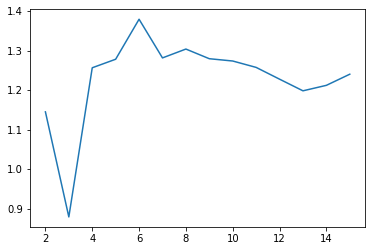

In [6]:
Db_R=[]
for i in trange(2,16) :
    nb_clusters = i
    kmeans_R = KMeans(init="k-means++", n_clusters=nb_clusters, max_iter=500, random_state=45).fit(data_R_db)
    kmeans_labels_R = kmeans_R.labels_
    db_index = davies_bouldin_score(data_R_db, kmeans_labels_R)
    Db_R.append(db_index)
    print(f"db index for Rabi with k = {nb_clusters} : ", db_index)
plt.plot(np.arange(2,16), Db_R)

  0%|          | 0/14 [00:00<?, ?it/s]

db index for Rabi with k = 2 :  1.4655587671808596
db index for Rabi with k = 3 :  1.2857888734877883
db index for Rabi with k = 4 :  1.4850622060802277
db index for Rabi with k = 5 :  1.4254887469403474
db index for Rabi with k = 6 :  1.426480270730597
db index for Rabi with k = 7 :  1.3718302945675784
db index for Rabi with k = 8 :  1.3505520872125294
db index for Rabi with k = 9 :  1.3498275263769122
db index for Rabi with k = 10 :  1.333617605398617
db index for Rabi with k = 11 :  1.2951664133413117
db index for Rabi with k = 12 :  1.29875386261543
db index for Rabi with k = 13 :  1.2396080143365629
db index for Rabi with k = 14 :  1.297223138400382
db index for Rabi with k = 15 :  1.2660613064401403


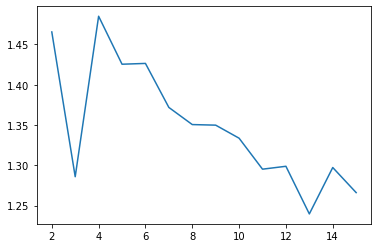

In [8]:
Db_K=[]
for i in trange(2,16) :
    nb_clusters = i
    kmeans_K = KMeans(init="k-means++", n_clusters=nb_clusters, max_iter=500, random_state=45).fit(data_K_db)
    kmeans_labels_K = kmeans_K.labels_
    db_index = davies_bouldin_score(data_K_db, kmeans_labels_K)
    Db_K.append(db_index)
    print(f"db index for Kharif with k = {nb_clusters} : ", db_index)
plt.plot(np.arange(2,16), Db_K)

In [32]:
nb_clusters_R = 7
kmeans_R = KMeans(init="k-means++", n_clusters=nb_clusters_R, max_iter=500, random_state=45).fit(data_R_db)
kmeans_labels_R = kmeans_R.labels_
db_index = davies_bouldin_score(data_R_db, kmeans_labels_R)
print(f"db index for Rabi with k = {nb_clusters_R} : ", db_index)

nb_clusters_K = 13
kmeans_K = KMeans(init="k-means++", n_clusters=nb_clusters_K, max_iter=500, random_state=45).fit(data_K_db)
kmeans_labels_K = kmeans_K.labels_
db_index = davies_bouldin_score(data_K_db, kmeans_labels_K)
print(f"db index for Rabi with k = {nb_clusters_K} : ", db_index)

db index for Rabi with k = 7 :  1.2816571762436146
db index for Rabi with k = 13 :  1.2396080143365629


In [19]:
#sauvegarder les labels optimaux 
labels_R = pd.DataFrame(kmeans_labels_R)
databis_R=df_R.reset_index()
labels_R=pd.concat((databis_R['key'],labels_R),axis=1).set_index('key')
# labels_R.to_csv("../../Outputs/kmeans_labels_Rabi_26-02")

labels_K = pd.DataFrame(kmeans_labels_K)
databis_K=df_K.reset_index()
labels_K=pd.concat((databis_K['key'],labels_K),axis=1).set_index('key')
# labels_K.to_csv("../../Outputs/kmeans_labels_Kharif_26-02")

### Interprétation clusters

In [20]:
labels_R = pd.DataFrame(kmeans_labels_R)
# labels_R = pd.read_csv("../../Outputs/Predictions/kmeans_labels_Rabi_14-02").drop(columns = ['key'])
databis_R=df_R.reset_index()
labeledData_R = pd.concat((databis_R,labels_R),axis=1)
labeledData_R = labeledData_R.rename({'0':'Label'},axis=1)
labeledData_R=labeledData_R.set_index(labeledData_R['key']).drop(columns = ['key'])
labeledData_R = regroupe_crop(labeledData_R)

labels_K = pd.DataFrame(kmeans_labels_K)
# labels_K = pd.read_csv("../../Outputs\Predictions\kmeans_labels_Kharif_14-02").drop(columns = ['key'])
databis_K=df_K.reset_index()
labeledData_K = pd.concat((databis_K,labels_K),axis=1)
labeledData_K = labeledData_K.rename({'0':'Label'},axis=1)
labeledData_K=labeledData_K.set_index(labeledData_K['key']).drop(columns = ['key'])
labeledData_K = regroupe_crop(labeledData_K)
labeledData_K.head()

,Crop,Area Sown (Ha),Area Insured (Ha),SI Per Ha (Inr/Ha),Lp_2011,Lp_2012,Lp_2013,Lp_2014,Lp_2015,Lp_2016,Lp_2017,Loss,0
key,,,,,,,,,,,,,
andhra pradesh_anantapur_agali__agali,Arhar,216.609811,0.168514,28750.0,0.843602,0.804674,0.874302,0.470271,0.840183,0.822226,0.0,14230.814316,6
andhra pradesh_anantapur_agali__akkagaladevarahalli,Arhar,216.609811,0.168514,28750.0,0.842151,0.802861,0.894883,0.579534,0.782517,0.820577,0.0,14464.016467,6
andhra pradesh_anantapur_agali__hulikeradevarahalli,Arhar,216.609811,0.168514,28750.0,0.843602,0.804674,0.879689,0.470271,0.840183,0.822226,0.0,14230.814316,6
andhra pradesh_anantapur_agali__inagalore,Arhar,216.609811,0.168514,28750.0,0.842151,0.802861,0.887634,0.579534,0.782517,0.820577,0.0,14464.016467,6
andhra pradesh_anantapur_agali__kodihalli,Arhar,216.609811,0.168514,28750.0,0.843602,0.804674,0.874302,0.470271,0.840183,0.822226,0.0,14230.814316,6


In [13]:
from pandas.plotting import parallel_coordinates
palette = sns.color_palette("bright", 10)

def display_parallel_coordinates(df, num_clusters):
    '''Display a parallel coordinates plot for the clusters in df'''

    # Select data points for individual clusters
    cluster_points = []
    for i in range(num_clusters):
        cluster_points.append(df[df.cluster==i])
    
    # Create the plot
    fig = plt.figure(figsize=(12, 15))
    title = fig.suptitle("Parallel Coordinates Plot for the Clusters", fontsize=18)
    fig.subplots_adjust(top=0.95, wspace=0)

    # Display one plot for each cluster, with the lines for the main cluster appearing over the lines for the other clusters
    for i in range(num_clusters):    
        plt.subplot(num_clusters, 1, i+1)
        for j,c in enumerate(cluster_points): 
            if i!= j:
                pc = parallel_coordinates(c, 'cluster', color=[addAlpha(palette[j],0.2)])
        pc = parallel_coordinates(cluster_points[i], 'cluster', color=[addAlpha(palette[i],0.5)])

        # Stagger the axes
        ax=plt.gca()
        for tick in ax.xaxis.get_major_ticks()[1::2]:
            tick.set_pad(20)        


def display_parallel_coordinates_centroids(df, num_clusters):
    '''Display a parallel coordinates plot for the centroids in df'''

    # Create the plot
    fig = plt.figure(figsize=(12, 5))
    title = fig.suptitle("Parallel Coordinates plot for the Centroids", fontsize=18)
    fig.subplots_adjust(top=0.9, wspace=0)

    # Draw the chart
    parallel_coordinates(df, 'cluster', color=palette)

    # Stagger the axes
    ax=plt.gca()
    for tick in ax.xaxis.get_major_ticks()[1::2]:
        tick.set_pad(20)    

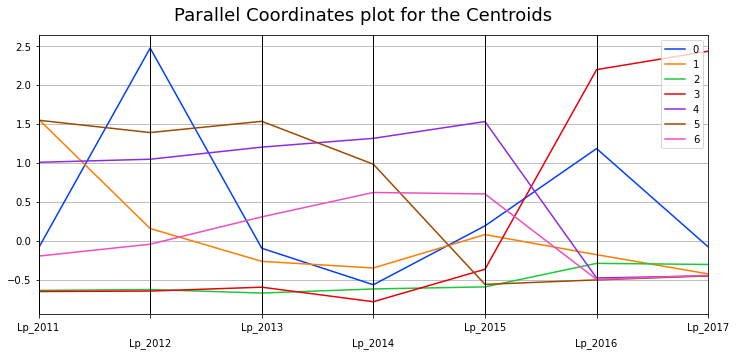

In [15]:
# Create a data frame containing our centroids
centroids = pd.DataFrame(kmeans_R.cluster_centers_, columns=data_R_db.columns)
centroids['cluster'] = centroids.index

display_parallel_coordinates_centroids(centroids, 7)

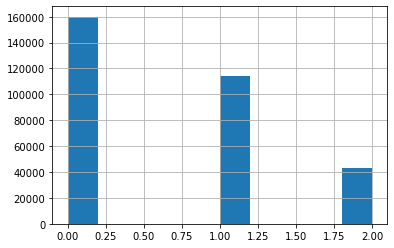

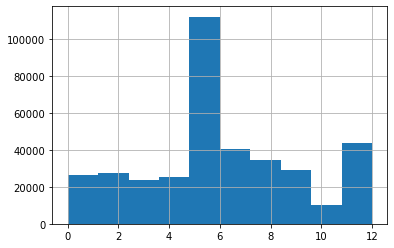

In [18]:
labeledData_R['Label'].hist()
plt.show()
labeledData_K['Label'].hist()
plt.show()


RABI


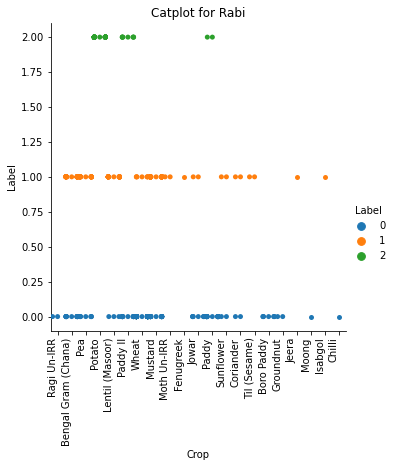

KHARIF


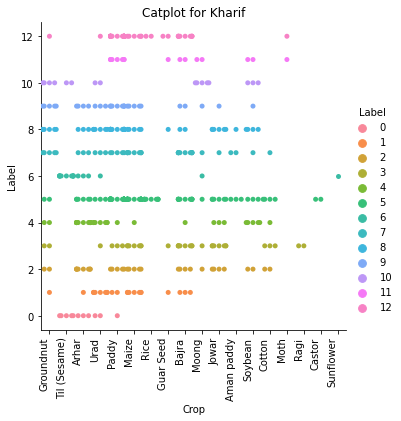

In [39]:
print("RABI")
labeledData_R.columns
sns.catplot(x='Crop', y='Label', kind="swarm", hue='Label', data=labeledData_R.sample(frac=1, random_state=0)[:500]) #sample is use to shuffle the rows of the dataset
plt.xticks(rotation=90, ha='right')
plt.title('Catplot for Kharif')
plt.show()

print("KHARIF")
labeledData_K.columns
sns.catplot(x='Crop', y='Label', kind="swarm", hue='Label', data=labeledData_K.sample(frac=1, random_state=0)[:500]) #sample is use to shuffle the rows of the dataset
plt.xticks(rotation=90, ha='right')
plt.title('Catplot for Kharif')
plt.show()

In [12]:
print("pca for Kharif")
pca_R = PCA(n_components=2,
     n_iter=10,
     copy=True,
     check_input=True,
     engine='sklearn',       ## Can be "auto", 'sklearn', 'fbpca'
     random_state=42).fit(data_R_db)
pca_data_R=pca_R.row_coordinates(data_R_db)

print("pca for Kharif")
pca_K = PCA(n_components=2,
     n_iter=10,
     copy=True,
     check_input=True,
     engine='sklearn',       ## Can be "auto", 'sklearn', 'fbpca'
     random_state=42).fit(data_K_db)
pca_data_K=pca_K.row_coordinates(data_K_db)

pca for Rabi
pca for Kharif


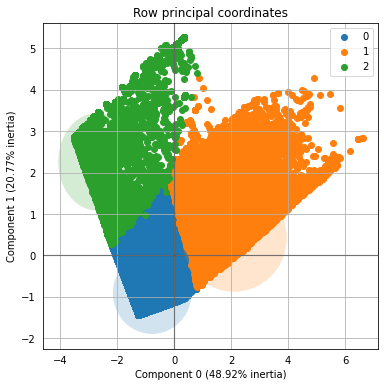

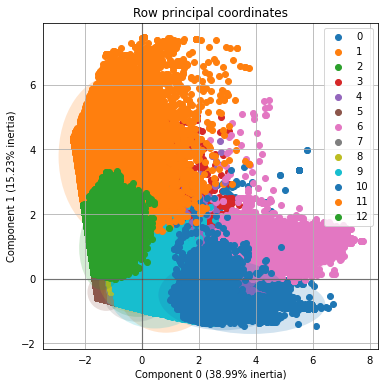

In [13]:
ax_R = pca_R.plot_row_coordinates(data_R_db, ax=None, figsize=(6, 6), x_component=0, y_component=1,
labels=None, color_labels=kmeans_labels_R, 
ellipse_outline=False, ellipse_fill=True, show_points=True)

ax_K = pca_K.plot_row_coordinates(data_K_db, ax=None, figsize=(6, 6), x_component=0, y_component=1,
labels=None, color_labels=kmeans_labels_K, 
ellipse_outline=False, ellipse_fill=True, show_points=True)

In [21]:
from sklearn.manifold import TSNE
import plotly.express as px

nb_samples = 3000
data_test = data_R_db
labels = pd.DataFrame(labels_R)

data_test  = data_test.reset_index()
data_test  = pd.concat((data_test,labels),axis=1)
data_test  = data_test.rename({'0':'Label'},axis=1)
data_test =data_test.set_index(data_test['key']).drop(columns = ['key'])
data_test = data_test.sample(frac=1, random_state=0)[:nb_samples]

In [22]:
tsne = TSNE(n_components=2, random_state=0)
projections = tsne.fit_transform(data_test.drop(columns=["Label"]))
fig = px.scatter(
    projections, x=0, y=1,
    color=data_test.Label.astype(str), labels={'color': 'Label'}
)
fig.show()

In [23]:
tsne = TSNE(n_components=3, random_state=0)
projections = tsne.fit_transform(data_test.drop(columns=["Label"]))
fig = px.scatter_3d(
    projections, x=0, y=1, z=2,
    color=data_test.Label.astype(str), labels={'color': 'Label'}
)
fig.update_traces(marker_size=8)
fig.show()

# K-Prototypes avec contraintes


In [26]:
def find_state(key) : 
    return key.split('_')[0]

collumns_db= [f'Lp_{i}' for i in range(2011,2018)] 
collumns = collumns_db + ['Crop']

Rabi = regroupe_crop(data_R)
Rabi = Rabi[collumns]
Rabi = Rabi.reset_index()
Rabi['State']=(Rabi.reset_index())['key'].map(find_state)
Rabi= Rabi.set_index('key')

Kharif = regroupe_crop(data_K)
Kharif = Kharif[collumns]
Kharif = Kharif.reset_index()
Kharif['State']=(Kharif.reset_index())['key'].map(find_state)
Kharif= Kharif.set_index('key')
Kharif.head()

,Lp_2011,Lp_2012,Lp_2013,Lp_2014,Lp_2015,Lp_2016,Lp_2017,Crop,State
key,,,,,,,,,
andhra pradesh_anantapur_agali__agali,3.202628,3.097340,2.966815,1.416728,2.163674,3.228176,-0.386329,Arhar,andhra pradesh
andhra pradesh_anantapur_agali__akkagaladevarahalli,3.195926,3.089027,3.053232,1.900648,1.955517,3.220697,-0.386329,Arhar,andhra pradesh
andhra pradesh_anantapur_agali__hulikeradevarahalli,3.202628,3.097340,2.989434,1.416728,2.163674,3.228176,-0.386329,Arhar,andhra pradesh
andhra pradesh_anantapur_agali__inagalore,3.195926,3.089027,3.022794,1.900648,1.955517,3.220697,-0.386329,Arhar,andhra pradesh
andhra pradesh_anantapur_agali__kodihalli,3.202628,3.097340,2.966815,1.416728,2.163674,3.228176,-0.386329,Arhar,andhra pradesh


In [44]:
def categorical_dissimilarity(a, b, **_):
    """Dissimilarity function with penalization"""
    return (a[:,0] != b[0])*5 + (a[:,1] != b[1])*5

# def euclidean_dissim(a, b, **_):
#     """Euclidean distance dissimilarity function"""
#     if np.isnan(a).any() or np.isnan(b).any():
#         raise ValueError("Missing values detected in numerical columns.")
#     return np.sum((a - b) ** 2, axis=1)*1e-15

nb_samples=1000
Rabi_test=Rabi.sample(frac=1, random_state=1)[:nb_samples]
# '7' = 'Crop' and '8' = 'District'
categorical_columns = [7,8]


nb_clusters_R = 7
kproto = KPrototypes(n_clusters= nb_clusters_R, init='Cao', n_jobs = 2, gamma= 1, 
                     cat_dissim=categorical_dissimilarity)
labels_R = kproto.fit_predict(Rabi_test, categorical=categorical_columns)


In [45]:
db_index = davies_bouldin_score(Rabi_test[collumns_db], labels_R)
db_index

2.578131634115234

In [46]:
centroids = pd.DataFrame(kproto.cluster_centroids_, columns=Rabi_test.columns)
centroids['cluster'] = centroids.index
centroids

,Lp_2011,Lp_2012,Lp_2013,Lp_2014,Lp_2015,Lp_2016,Lp_2017,Crop,State,cluster
0,-0.6743458543804628,-0.6261006395327404,-0.6284092377205238,-0.46509414919985465,-0.5333639263512614,-0.38278635995867544,-0.36753724522502446,Wheat,uttar pradesh,0
1,1.00200584801005,0.5571427248584699,0.4982583577803283,0.6704420764300114,0.5404507808753253,-0.42666290375379146,-0.4513949475366858,Mustard,uttar pradesh,1
2,-0.4268024023977583,-0.43299762230875644,-0.716673445643818,-0.8895815648011778,-0.5082256121415571,-0.006155214005826446,-0.15914979561111245,Paddy,tamil nadu,2
3,0.07857289285798924,-0.044977071584656324,0.557620725519921,0.7447267894864742,0.9805235279772746,-0.40379966399264283,-0.4161275273444614,Bengal Gram (Chana),uttar pradesh,3
4,0.95802852625009,1.4684219746846245,0.9866470859992066,1.180954332930987,1.0451697335582197,-0.45759072095627634,-0.45139494753668685,Lentil (Masoor),uttar pradesh,4
5,-0.6068497587289775,-0.5648894656727593,-0.4645302924624885,-0.8133709402261662,-0.37369158598897506,2.274104349647037,2.531458603703954,Potato,uttar pradesh,5
6,1.8343903347198622,1.595925976858753,1.4388411503094156,0.4865684609918829,-0.5173156257025955,-0.28837384110671527,-0.43654196805566003,Bengal Gram (Chana),madhya pradesh,6


In [47]:
labeledData_R = Rabi_test.copy(deep=True)
labeledData_R['Label'] = np.array(labels_R).astype(int)

# labeledData_K = Kharif_test.copy(deep=True)
# labeledData_K['Label'] = np.array(labels_K)
# # labels_K = pd.read_csv("../../Outputs\Predictions\kmeans_labels_Kharif_14-02").drop(columns = ['key'])

In [48]:
# labeledData_R['Label'].hist()
# labeledData_R.groupby('Crop')['Label'].value_counts()

RABI


<Figure size 5040x5040 with 0 Axes>

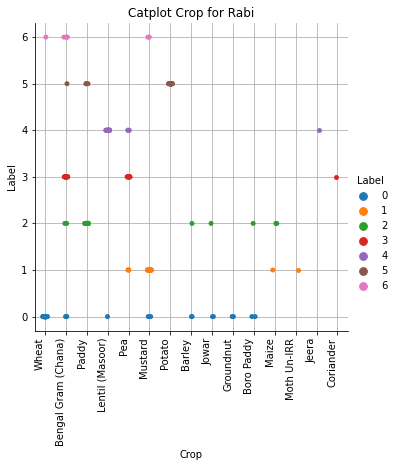

RABI


<Figure size 5040x5040 with 0 Axes>

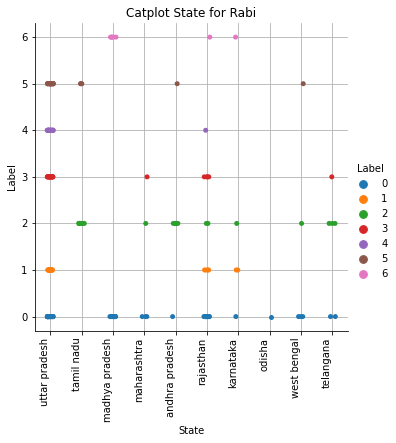

In [49]:
print("RABI")
labeledData_R.columns
plt.figure(figsize=(70,70)) 
sns.catplot(x='Crop', y='Label', hue='Label', data=labeledData_R.sample(frac=1, random_state=0)[:200]) #sample is use to shuffle the rows of the dataset
plt.xticks(rotation=90, ha='right')
plt.title('Catplot Crop for Rabi')
plt.grid()
plt.show()

print("RABI")
labeledData_R.columns
plt.figure(figsize=(70,70)) 
sns.catplot(x='State', y='Label', hue='Label', data=labeledData_R.sample(frac=1, random_state=0)[:200]) #sample is use to shuffle the rows of the dataset
plt.xticks(rotation=90, ha='right')
plt.title('Catplot State for Rabi')
plt.grid()
plt.show()

In [ ]:
# Db_K=[]
# for i in trange(2,16) :
#     nb_clusters = i
#     kmeans_K = KMeans(init="k-means++", n_clusters=nb_clusters, max_iter=500, random_state=45).fit(data_K_db)
#     kmeans_labels_K = kmeans_K.labels_
#     db_index = davies_bouldin_score(data_K_db, kmeans_labels_K)
#     Db_K.append(db_index)
#     print(f"db index for Kharif with k = {nb_clusters} : ", db_index)
# plt.plot(np.arange(2,16), Db_K)

# Clustering State Level

The idea is to re-use the clusters from the previous analysis (parcel level) and choose the most represented clusters for each state

<AxesSubplot:>

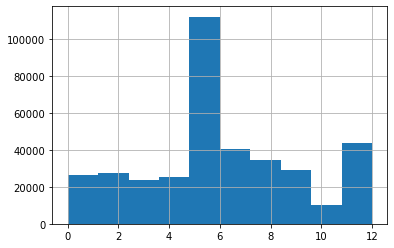

In [86]:
df_pred_R = pd.read_csv("../../Outputs/Predictions\kmeans_labels_Rabi_26-02").rename({'0':'Label'},axis=1)
df_pred_K = pd.read_csv("../../Outputs/Predictions\kmeans_labels_Kharif_26-02").rename({'0':'Label'},axis=1)
df_pred_K['Label'].hist()

In [89]:
def find_state(key) : 
    return key.split('_')[0]

def clusters_state(df_pred) :
    new_df = df_pred.copy(deep=True)
    new_df['State']=new_df['key'].map(find_state)
    new_df['State_Label'] = new_df.groupby(new_df['State'])['Label'].transform(lambda x: x.value_counts().idxmax())
    return new_df

In [91]:
df_predState_R = clusters_state(df_pred_R)
df_predState_K = clusters_state(df_pred_K)
df_predState_R.head()

,key,Label,State,State_Label
0,andhra pradesh_anantapur_vidapanakal___,6,andhra pradesh,2
1,andhra pradesh_anantapur_vajrakarur___,2,andhra pradesh,2
2,andhra pradesh_anantapur_gooty___,1,andhra pradesh,2
3,andhra pradesh_anantapur_guntakal___,1,andhra pradesh,2
4,andhra pradesh_anantapur_pamidi___,1,andhra pradesh,2


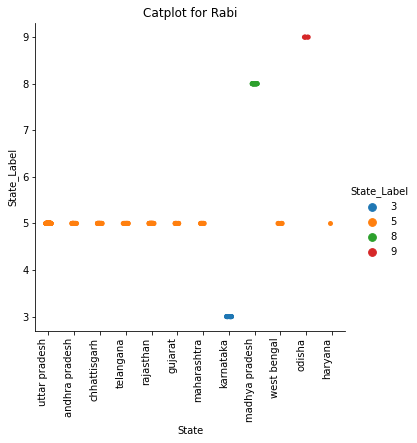

In [94]:
sns.catplot(x='State', y='State_Label', hue='State_Label', data=df_predState_K.sample(frac=1, random_state=0)[:500]) #sample is use to shuffle the rows of the dataset
plt.xticks(rotation=90, ha='right')
plt.title('Catplot for Rabi')
plt.show()